In [2]:
# Packages

# Datos
import pandas as pd
import numpy as np
from scipy import stats 
import copy
import pingouin as pg

# Análisis de Factores
from sklearn.decomposition import FactorAnalysis

# Visualizaciones
import plotly.express as px
import seaborn as sb

pd.DataFrame.iteritems = pd.DataFrame.items


DATA_PATH = '/home/chay/EstadisticaMultivariada/NBA_Playoffs/data/'

# Análisis de Factores para los finalistas de los Playoffs NBA 2023-2024

Autores:
- Guillermo Sierra Vargas
- Isaias Siliceo Guzmán


Estadística Multivariada
11/06/2024

# Funciones

In [3]:
# Función para graficar una matriz de correlaciones en un mapa de calor
def plot_heatmap(Corr_mtx):
    sb.set_theme(rc={'figure.figsize':(10,8)})
    sb.heatmap(Corr_mtx, cmap="YlGnBu", annot=False) 

In [4]:
def plot_relations(df,dims,color):
    fig = px.scatter_matrix(df,dimensions=dims,
                       title='Diagrama de dispersión multiple',color=color)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800
    )
    fig.show()

In [5]:
# Función para ordenar los eigenvectors de acuerdo a los eigenvalues
def sorted_eig(evals,evecs):
    # Se obtienen los índices de los evals en orden de mayor a menor
    idx = evals.argsort()[::-1]
    # Se ordenan los eigenvalores de mayor a menor
    evals = evals[idx]
    # Se ordenan los eigenvectores de mayor a menor
    evecs = evecs[:,idx]
    # Se seleccionan aquellos mayores a cero
    evals = evals[evals>0]
    # Se ordenan en un arreglo
    evecs = np.array([list(evecs[:,i]) for i in range(len(evals))])
    evecs = evecs.T

    return evals, evecs

In [6]:
# Implementation of principal component method to estimate Loading matrix
def principal_comp_method(m,evals, evecs):
    # Build the estimated loading matrix L
    #Lr = np.array([np.dot(np.sqrt(evals[i]),evecs[:,i]) for i in range(m)]).T
    Lr = np.array([np.dot(np.sqrt(evals[i]),evecs[i]) for i in range(m)])

    # Renormalizamos los vectores de Lr
    Lr = np.array([Lr[i]/np.linalg.norm(Lr[i]) for i in range(len(Lr))]).T
    
    # Estimate the communalities by a sum over 
    communalities = np.sum(Lr**2,axis=1)

    Psi = np.ones(len(communalities))-communalities
    
    # Return Lr and communalities
    return Lr, communalities, Psi

In [107]:
""" Método del factor principal
    para estimar la matriz de cargas
    Input: Matriz S o R
           eps 
    Output: Matriz de cargas Lr
           Communalities

    If corr is set to False the method is applied with Covariance matrix
    If corr is set to True, first we compute the correlation matrix.
    """
def principal_factor_method(mtx,m_val,eps,corr):
    
    # If corr True, then we compute the correlation matrix
    dim = len(mtx)
    if (corr == True):
        D = 1 /np.sqrt(np.diag(mtx))*np.eye(dim)
        mtx = np.dot(D,np.dot(mtx,D))
        # Compute the inverse of mtx
        mtx_inv = np.linalg.inv(mtx)
        # Compute the first communalities
        communalities0 = [1 - 1/mtx_inv[i,i] for i in range(dim)]
    else:
        mtx_inv = np.linalg.inv(mtx)
        # Compute the first communalities
        communalities0 = [np.diag(mtx)[i] - 1/mtx_inv[i,i] for i in range(dim)]
    
    # Substitute communalities into original matrix diagonal
    mtx_r0 = mtx - np.diag(mtx)*np.eye(dim) + communalities0*np.eye(dim)
    # Compute the eigenvalues and eigenvectors of the reduced matrix
    evals_0, evecs_0 = np.linalg.eig(mtx_r0)
    #print(evals_0)
    # Sort and filter the eigenvalues and eigenvectors
    evals_0, evecs_0 = sorted_eig(evals_0,evecs_0)
    #print(evals_0)
    # Build the reduced loading matrix Lr_0
    Lr_0 = np.array([np.sqrt(evals_0[i])*evecs_0[:,i] for i in range(m_val)]).T
    #print(Lr_0)
    # Initialize eps1
    eps1 = eps+1;
    while(eps < eps1):
        # Compute the new communalities from Lr_0
        communalities1 = np.diag(np.dot(Lr_0,Lr_0.T))
        #print(communalities1)
        # Compute the new reduced correlation matrix
        mtx_r1 = mtx_r0 - np.diag(mtx_r0)*np.eye(dim) + communalities1*np.eye(dim)
        # Compute the eigenvalues and eigenvectors of the new reduced matrix
        evals_1, evecs_1 = np.linalg.eig(mtx_r1)
        #print(evals_1)
        # Sort and filter the new eigenvalues and eigenvectors
        evals_1, evecs_1 = sorted_eig(evals_1,evecs_1)
        # Build the reduced loading matrix Lr_1
        Lr_1 = np.array([np.sqrt(evals_1[i])*evecs_1[:,i] for i in range(m_val)]).T
        # Compute the L1 norm of ||Lr_1-Lr_0||
        eps1 = max(abs(np.sum(Lr_1-Lr_0,axis=0)))
        # The new loading matrix is now the initial loading matrix
        Lr_0  = Lr_1
        # The new reduced matrix is now the initial reduced matrix
        mtx_r0 = mtx_r1
    
    Psi = np.ones(len(communalities1))-communalities1

    return Lr_1, communalities1, Psi

# Function to print the information i.e. Loading matrix, Communalities,
# Specific variances, Variance percentage of each variables, cumulative variance.
def print_info(m,p,Lmtx,com_mtx):
    print('Matriz de cargas para m=%d'%(m))
    for i in range(m):
        print('\tF%d\t'%(i+1),end=' ')
    
    print('\n',np.round(Lmtx,3))
    print('\n Comunalidades \t Varianzas Específicas')
    for i in range(p):
        print('h'+str(i+1)+'^2 = ',np.round(com_mtx[i],2),end='\t')
        print('psi'+str(i+1)+' = ',np.round(1-com_mtx[i],2))


def print_info2(m,p,com_mtx,cum_var):
    print('\nPorcentaje que supone la comunalidad \nrespecto a la varianza de cada variable. (hi^2/Var(Xi))*100%')
    for i in range(p):
        print('h%d^2/var(X%d)'%(i+1,i+1)+'= ',np.round(com_mtx[i],2)*100,'%')

    print('\nVarianza acumulada para m=%d factores y p=%d variables'%(m,p))
    for i in range(m):
        print('var_acum%d = %f'%(i+1,cum_var[i]))

In [99]:
# Function to compute the Fscores using the result of weighted least squares
def factor_scores_LS(Lz,psi,Xdat):
    fact_scores =np.array([
        np.dot(np.dot(np.linalg.inv(np.dot(Lz.T,np.dot(np.linalg.inv(psi),Lz))),np.dot(Lz.T,np.linalg.inv(psi))),Xdat.loc[[i]].T)
        for i in range(len(Xdat))
    ])
    fact_scores = fact_scores.reshape(len(Xdat),len(Lz[0]))
    return fact_scores

# Function to compute the Fscores using the result of Regression
def factor_scores_Reg(Lz,psi,Xdat):
    fact_scores =np.array([
        np.dot(np.dot(Lz.T,np.linalg.inv(np.dot(Lz,Lz.T)+psi)),Xdat.loc[[i]].T)
        for i in range(len(Xdat))
    ])
    fact_scores = fact_scores.reshape(len(Xdat),len(Lz[0]))
    return fact_scores

def argmax_of_three(row):
    return row[[0,1,2]].idxmax()

In [118]:
def plot_FA(df,f1,f2,labels,names,position,legend_title):
    
    fig = px.scatter(df, x=f1, y=f2,text=names,color=position
                 ,width=800, height=700,custom_data=['Player','Team','Pos','Age','Ht','Wt','PPG','RPG','APG','PIE'])

    fig.update_layout(
        legend_title_text=legend_title,
        title= 'Proyección de Jugadores',
        xaxis_title = labels[0],
        yaxis_title = labels[1],
        font=dict(
            family="Courier New, monospace",
            size=18,  # Set the font size here
        )
    )
    fig.update_traces(marker=dict(size=20),textposition='bottom center',textfont_size=14,
                      hovertemplate="<b style='font-size:16px; color:#000000;'> %{customdata[0]}</b><br>"+"Team: %{customdata[1]}<br>" +
                      "Position: %{customdata[2]}<br>"+"Age: %{customdata[3]} years<br>"+"Height: %{customdata[4]} m<br>"
                      +"Weight: %{customdata[5]} kg<br>"+"PPG: %{customdata[6]}<br>"
                      +"RPG: %{customdata[7]}<br>"+"APG: %{customdata[8]}<br>"+"PIE: %{customdata[9]}<br>"+"<extra></extra>")
    fig.show()

In [139]:
# Function to fit Factor Analysis model using Maximum Likelihood estimate
# and a certain rotation
def fit_FA(Xdat,m_fctrs, rot):
    transformer = FactorAnalysis(n_components=m_fctrs, random_state=0,rotation=rot)
    transformer.fit(Xdat)

    # Compute the Loading matrix
    Lmtx = transformer.components_.T

    # Specific variance matrix
    PsiE = transformer.noise_variance_
    
    return Lmtx, PsiE

In [156]:
# Level of significance 
alpha_5 = 0.05

# Function to prove hypothesis 
def decision(n,p,m,Lmtx,Psi,Rmtx,alpha):
    left_val = (n-1-(2*p+4*m+5)/6)
    deg_freedom = ((p-m)**2-p-m)/2
    print('Grados de libertad: ',deg_freedom)
    chi_5m = stats.chi2.ppf(1-alpha, deg_freedom)
    print('Estadístico Chi cuadrado',chi_5m)
    detL = np.linalg.det(np.dot(Lmtx,Lmtx.T)+Psi*np.eye(len(Rmtx)))
    detR = np.linalg.det(Rmtx)
    statistic = left_val * np.log(detL/detR)
    decision = statistic > chi_5m

    if (decision == True):
        print('El valor del estadístico de prueba es:',statistic)
        print('%f > %f'%(statistic,chi_5m))
        print('De modo, que la hipótesis H0 se rechaza con un grado de confianza de',1-alpha)
    else:
        print('El valor del estadístico de prueba es:',statistic)
        print('%f < %f'%(statistic,chi_5m))
        print('De modo, que la hipótesis H0 NO se rechaza con un grado de confianza de ',1-alpha)

# Lectura de datos

In [8]:
# Se leen los datos de los jugadores 
Boston = pd.read_excel(DATA_PATH+'L15_Games.xlsx',sheet_name=0)
Dallas = pd.read_excel(DATA_PATH+'L15_Games.xlsx',sheet_name=1)

In [9]:
# Concatenamos los datos de Boston y Dallas en un solo dataframe.
# Además, se seleccionan sólo las primeras 16 columnas
Celtics = Boston.iloc[:,:12]
Mavericks = Dallas.iloc[:,:12]
Players = pd.concat([Celtics,Mavericks],axis=0)
Players.columns

Index(['Player', 'Team', 'Pos', 'Age', 'Ht', 'Wt', 'Exp', 'Country', 'PPG',
       'RPG', 'APG', 'PIE'],
      dtype='object')

In [10]:
Players.head()

,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
0,Jayson Tatum,BOS,F-G,26,2.03,95,6,USA,26.9,8.1,4.9,15.5
1,Jaylen Brown,BOS,F,27,1.98,101,7,USA,23.0,5.5,3.6,11.6
2,Derrick White,BOS,G,29,1.93,86,6,USA,15.2,4.2,5.2,10.6
3,Jrue Holiday,BOS,G,33,1.93,93,14,USA,12.5,5.4,4.8,9.9
4,Al Horford,BOS,C-F,38,2.06,109,16,DOM,8.6,6.4,2.6,10.5


In [12]:
# Se calculan esstadísticos relevantes
np.round(Players.describe(),2)

,Age,Ht,Wt,Exp,PPG,RPG,APG,PIE
count,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00
mean,26.68,2.01,98.54,5.39,10.82,4.29,2.37,9.76
std,4.29,0.08,8.94,3.98,8.19,2.13,2.06,3.32
min,20.00,1.85,81.00,0.00,1.70,1.20,0.50,5.50
25%,24.75,1.96,92.75,2.75,5.08,3.12,1.00,7.68
50%,26.00,2.01,96.00,5.00,8.60,3.70,1.60,8.95
75%,28.25,2.06,106.75,7.00,13.28,5.52,3.02,11.38
max,38.00,2.18,113.00,16.00,33.90,9.20,9.80,20.00


In [169]:
Players

,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
0,Jayson Tatum,BOS,F-G,26,2.03,95,6,USA,26.9,8.1,4.9,15.5
1,Jaylen Brown,BOS,F,27,1.98,101,7,USA,23.0,5.5,3.6,11.6
2,Derrick White,BOS,G,29,1.93,86,6,USA,15.2,4.2,5.2,10.6
3,Jrue Holiday,BOS,G,33,1.93,93,14,USA,12.5,5.4,4.8,9.9
4,Al Horford,BOS,C-F,38,2.06,109,16,DOM,8.6,6.4,2.6,10.5
5,Payton Pritchard,BOS,G,26,1.85,88,3,USA,9.6,3.2,3.4,10.3
6,Sam Hauser,BOS,F,26,2.01,98,2,USA,9.0,3.5,1.0,8.6
7,Kristaps Porzingis,BOS,F-C,28,2.18,109,7,LAT,20.1,7.2,2.0,13.8
8,Luke Kornet,BOS,C-F,28,2.16,113,6,USA,5.3,4.1,1.1,11.3
9,Oshae Brissett,BOS,F-G,25,2.01,95,4,CAN,3.7,2.9,0.8,7.6


In [13]:
Players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 0 to 12
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   28 non-null     object 
 1   Team     28 non-null     object 
 2   Pos      28 non-null     object 
 3   Age      28 non-null     int64  
 4   Ht       28 non-null     float64
 5   Wt       28 non-null     int64  
 6   Exp      28 non-null     int64  
 7   Country  28 non-null     object 
 8   PPG      28 non-null     float64
 9   RPG      28 non-null     float64
 10  APG      28 non-null     float64
 11  PIE      28 non-null     float64
dtypes: float64(5), int64(3), object(4)
memory usage: 2.8+ KB


In [14]:
# Separamos las variables numéricas de las categóricas
NumericalVars = ['Age','Ht','Wt','Exp','PPG','RPG','APG','PIE']
CategoricalVars = ['Player','Team','Pos','Country']
NumPlayers = Players[NumericalVars]
CatPlayers = Players[CategoricalVars]

In [15]:
# Estandarizamos los datos
NumPlayers_z  = copy.deepcopy(NumPlayers)
NumPlayers_z = stats.zscore(NumPlayers_z)

In [16]:
# Se corrige el índice de los datos
NumPlayers_z = NumPlayers_z.reset_index(drop=True)

# Distribución de los datos

In [17]:
fig = px.box(NumPlayers, y='Age',width=600,height=600)
fig.show()

In [24]:
Players[Players['Age']>33]

,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
4,Al Horford,BOS,C-F,38,2.06,109,16,DOM,8.6,6.4,2.6,10.5


In [18]:
fig = px.box(NumPlayers, y='Ht',width=600,height=600)
fig.show()

In [19]:
fig = px.box(NumPlayers, y='Wt',width=600,height=600)
fig.show()

In [20]:
fig = px.box(NumPlayers, y='Exp',width=600,height=600)
fig.show()

In [26]:
Players[Players['Exp']>12]

,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
3,Jrue Holiday,BOS,G,33,1.93,93,14,USA,12.5,5.4,4.8,9.9
4,Al Horford,BOS,C-F,38,2.06,109,16,DOM,8.6,6.4,2.6,10.5


In [21]:
fig = px.box(NumPlayers, y='PPG',width=600,height=600)
fig.show()

In [27]:
Players[Players['PPG']>25]

,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
0,Jayson Tatum,BOS,F-G,26,2.03,95,6,USA,26.9,8.1,4.9,15.5
0,Luka Doncic,DAL,F-G,25,2.01,104,5,SLV,33.9,9.2,9.8,20.0
1,Kyrie Irving,DAL,G,32,1.88,88,12,AUS,25.6,5.0,5.2,14.4


In [22]:
fig = px.box(NumPlayers, y='RPG',width=600,height=600)
fig.show()

In [23]:
fig = px.box(NumPlayers, y='APG',width=600,height=600)
fig.show()

In [28]:
Players[Players['APG']>5]

,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
2,Derrick White,BOS,G,29,1.93,86,6,USA,15.2,4.2,5.2,10.6
0,Luka Doncic,DAL,F-G,25,2.01,104,5,SLV,33.9,9.2,9.8,20.0
1,Kyrie Irving,DAL,G,32,1.88,88,12,AUS,25.6,5.0,5.2,14.4


In [29]:
fig = px.box(NumPlayers, y='PIE',width=600,height=600)
fig.show()

In [30]:
Players[Players['PIE']>15]

,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
0,Jayson Tatum,BOS,F-G,26,2.03,95,6,USA,26.9,8.1,4.9,15.5
0,Luka Doncic,DAL,F-G,25,2.01,104,5,SLV,33.9,9.2,9.8,20.0


# Correlaciones

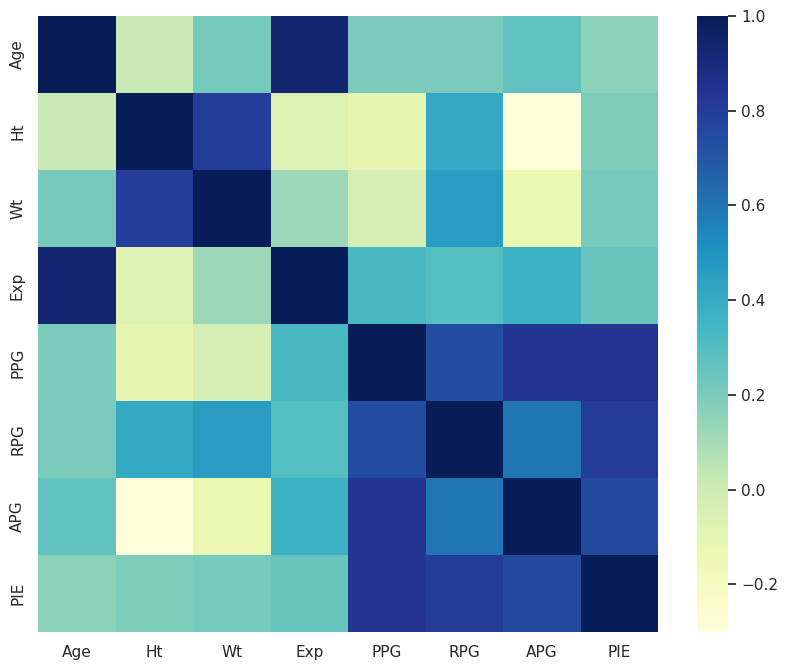

In [31]:
plot_heatmap(NumPlayers_z.corr())

## Se observan las zonas oscuras del mapa de calor

In [32]:
plot_relations(NumPlayers_z,['Age','Ht','Wt','Exp'],CatPlayers['Team'])

In [33]:
plot_relations(NumPlayers_z,['PPG','RPG','APG','PIE'],CatPlayers['Team'])

# Prueba de Normalidad

In [34]:
print(pg.multivariate_normality(NumPlayers_z)) # Multivariate normality

HZResults(hz=0.9714141594109471, pval=0.05821948886120327, normal=True)


In [61]:
n = len(NumPlayers)
m = len(NumPlayers.columns)

In [48]:
Smtx = NumPlayers.cov()
mu = NumPlayers.mean(axis=0)

In [59]:
# Agregamos la distancia cuadrada generalizada a NumPlayers
SqDist = NumPlayers.apply(lambda x : np.dot(np.dot((x[:]-mu).T,np.linalg.inv(Smtx)),x[:]-mu),axis=1).to_numpy()

# Se ordenan
SqDist = np.sort(SqDist)
SqDist

array([ 1.35043139,  2.32689137,  3.02788606,  4.01491716,  4.38550672,
        4.57344086,  4.81236966,  5.28272078,  5.81213259,  5.84548462,
        6.20148537,  6.29276925,  6.3337361 ,  7.2048494 ,  7.47145777,
        7.63252084,  8.58355155,  8.62979287,  8.79662838,  9.65967782,
        9.82907752,  9.89505956, 10.08542632, 11.62358902, 11.72343668,
       11.73915122, 13.93570202, 18.9303071 ])

In [66]:
# Obtenemos una lista de los percentiles de una distribución chi cuadrada con
# con p=8 y entre el número de datos 28
chi_percentiles = np.array([stats.chi2.ppf(((j-1/2)/n), m) for j in range(1,n+1)])

In [67]:
chi_percentiles

array([ 1.96240249,  2.79726998,  3.34727258,  3.79651499,  4.19319263,
        4.55830994,  4.90332537,  5.23542386,  5.55959707,  5.87961945,
        6.19856889,  6.51913731,  6.84383827,  7.1751652 ,  7.51573115,
        7.86841235,  8.23651661,  8.62400284,  9.03579054,  9.47822557,
        9.95982315, 10.49252911, 11.09402052, 11.79230041, 12.63606776,
       13.7226978 , 15.29980842, 18.48705405])

In [85]:
# Agregamos esto a un dataframe
ChiDF = np.concatenate(([SqDist],[chi_percentiles]),axis=0).T
ChiDF = pd.DataFrame(ChiDF,columns=['Sq','Chi'])

In [98]:
fig = px.scatter(ChiDF,x = 'Chi',y='Sq',width = 650,height=600)
fig.update_layout(
    title= 'Gráfico Chi-cuadrada',
    xaxis_title="Percentiles de Chi-cuadrada",
    yaxis_title="Distancia Cuadrada generalizada",
    font=dict(
        family="Courier New, monospace",
        size=18,  # Set the font size here
    )
)
fig.update_traces(marker=dict(size=10))
# Add the y = x line
fig.add_shape(
    type="line",
    x0=0, y0=0,
    x1=1, y1=1,
    xref='paper', yref='paper',
    line=dict(color="Black", width=2, dash="dash")
)

# Análisis de Factores

## 1. Por componentes principales

### Calcular Screeplot y Varianza acumulada

In [110]:
# Se calcula la matriz de correlación
R_mtx = NumPlayers_z.corr()
# Se calculan los valores y vectores propios
evals,evecs = np.linalg.eig(R_mtx)
# Se ordenan los eigenvectores de acuerdo a los eigenvalores
evals_s , evecs_s = sorted_eig(evals,evecs)

np.round(evals_s,3)

array([3.669, 2.064, 1.637, 0.224, 0.169, 0.106, 0.083, 0.048])

Por el criterio de Kaiser, 3 componentes son suficientes para describir a los datos.

In [103]:
# Calculamos la varianza acumulada
variance_pc = evals_s/np.sum(len(R_mtx))
cum_var_pc = np.cumsum(variance_pc)
print('Varianza explicada con tres componentes: %2f '%(cum_var_pc[2]*100))

fig = px.line(x=np.arange(1,9),y=variance_pc,width=600, height=500)
fig.update_layout(
    title = 'Gráfico de codo',
    xaxis_title="Componentes",
    yaxis_title="Varianza",
    font=dict(
        family="Courier New, monospace",
        size=18,  # Set the font size here
    )
)
fig.update_xaxes(range=[1, 8])
fig.show()

Varianza explicada con tres componentes: 92.128801 


In [104]:
fig = px.line(x=np.arange(1,9),y=cum_var_pc,width=600, height=500)
fig.update_layout(
    title = 'Varianza acumulada',
    xaxis_title="Componentes",
    yaxis_title="Varianza acumulada",
    font=dict(
        family="Courier New, monospace",
        size=18,  # Set the font size here
    )
)
fig.update_xaxes(range=[1, 8])
fig.show()

### Determinar matriz de factores L, hs y Psi

In [108]:
# Llamamos a la función de principal_comp_method
L_mtx, hs, Psi = principal_comp_method(3,evals_s,evecs_s)
print_info(3,len(R_mtx),L_mtx,hs)

Matriz de cargas para m=3
	F1	 	F2	 	F3	 
 [[ 0.257  0.074  0.146]
 [ 0.004  0.659  0.622]
 [ 0.668 -0.061  0.071]
 [-0.009 -0.429  0.67 ]
 [-0.175 -0.23   0.025]
 [ 0.026  0.254 -0.347]
 [ 0.16   0.477 -0.101]
 [ 0.657 -0.164 -0.079]]

 Comunalidades 	 Varianzas Específicas
h1^2 =  0.09	psi1 =  0.91
h2^2 =  0.82	psi2 =  0.18
h3^2 =  0.45	psi3 =  0.55
h4^2 =  0.63	psi4 =  0.37
h5^2 =  0.08	psi5 =  0.92
h6^2 =  0.19	psi6 =  0.81
h7^2 =  0.26	psi7 =  0.74
h8^2 =  0.46	psi8 =  0.54


No son muy interpretables los factores
- El factor 1 describe: Age, Wt, PIE
- El factor 2 describe: Ht,PPG, APG
- El factor 3 describe: Exp,RPG

In [109]:
print_info2(3,len(R_mtx),hs,cum_var_pc)


Porcentaje que supone la comunalidad 
respecto a la varianza de cada variable. (hi^2/Var(Xi))*100%
h1^2/var(X1)=  9.0 %
h2^2/var(X2)=  82.0 %
h3^2/var(X3)=  45.0 %
h4^2/var(X4)=  63.0 %
h5^2/var(X5)=  8.0 %
h6^2/var(X6)=  19.0 %
h7^2/var(X7)=  26.0 %
h8^2/var(X8)=  46.0 %

Varianza acumulada para m=3 factores y p=8 variables
var_acum1 = 0.458669
var_acum2 = 0.716639
var_acum3 = 0.921288


### Calcular Factor Scores

In [111]:
# Como estos datos se generaron con el método de componentes principales y estamos utilizando los
# datos estandarizados entonces utilizamos una regresión lineal No ponderada
f_scores = np.array([
    np.dot(np.dot(np.linalg.inv(np.dot(L_mtx.T,L_mtx)),L_mtx.T),NumPlayers_z.loc[i]) for i in range(len(NumPlayers_z))
])

In [112]:
# Se crea el dataframe para los Celtics
f_scoresDf = pd.DataFrame(f_scores,columns=['F1','F2','F3'])
Players.reset_index(drop=True, inplace=True)
f_scoresDf.reset_index(drop=True,inplace=True)
f_scoresDf = pd.concat([f_scoresDf,Players],axis=1)
f_scoresDf.head()

,F1,F2,F3,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
0,0.744397,0.424375,-0.637466,Jayson Tatum,BOS,F-G,26,2.03,95,6,USA,26.9,8.1,4.9,15.5
1,0.420493,-0.424823,-0.182264,Jaylen Brown,BOS,F,27,1.98,101,7,USA,23.0,5.5,3.6,11.6
2,-0.520373,-0.083642,-0.648681,Derrick White,BOS,G,29,1.93,86,6,USA,15.2,4.2,5.2,10.6
3,0.138342,-0.775748,0.746151,Jrue Holiday,BOS,G,33,1.93,93,14,USA,12.5,5.4,4.8,9.9
4,1.705285,-0.290953,2.295075,Al Horford,BOS,C-F,38,2.06,109,16,DOM,8.6,6.4,2.6,10.5


### Gráficos ilustrativos

In [121]:
plot_FA(f_scoresDf,'F1','F2',['Age, Wt y PIE','Ht, PPG y APG'],'Player','Team','Team')

In [122]:
plot_FA(f_scoresDf,'F1','F2',['Age, Wt y PIE','Ht, PPG y APG'],'Player','Pos','Position')

In [123]:
plot_FA(f_scoresDf,'F1','F3',['Age y PIE','Exp y RPG'],'Player','Team','Team')

In [124]:
plot_FA(f_scoresDf,'F1','F3',['Age y PIE','Exp y RPG'],'Player','Pos','Position')

In [125]:
plot_FA(f_scoresDf,'F2','F3',['Ht, PPG y APG','Exp y RPG'],'Player','Team','Team')

In [126]:
plot_FA(f_scoresDf,'F2','F3',['Ht, PPG y APG','Exp y RPG'],'Player','Pos','Position')

## 2. Rotación por Método de Factor principal

In [127]:
eps = 0.01
L_mtx_rot, hs_rot, Psi_rot = principal_factor_method(R_mtx,3,eps,False)
print_info(3,len(R_mtx),L_mtx_rot,hs_rot)

Matriz de cargas para m=3
	F1	 	F2	 	F3	 
 [[ 0.497 -0.003  0.833]
 [ 0.134  0.931 -0.057]
 [ 0.262  0.825  0.092]
 [ 0.589 -0.106  0.757]
 [ 0.869 -0.258 -0.281]
 [ 0.844  0.302 -0.243]
 [ 0.806 -0.419 -0.173]
 [ 0.865  0.034 -0.332]]

 Comunalidades 	 Varianzas Específicas
h1^2 =  0.93	psi1 =  0.07
h2^2 =  0.87	psi2 =  0.13
h3^2 =  0.76	psi3 =  0.24
h4^2 =  0.93	psi4 =  0.07
h5^2 =  0.9	psi5 =  0.1
h6^2 =  0.86	psi6 =  0.14
h7^2 =  0.86	psi7 =  0.14
h8^2 =  0.86	psi8 =  0.14


### Determinar matriz de factores L, hs y Psi

El factor 1 explica sus habilidades en la cancha. El segundo son los factores asociados al peso y altura. Mientras que el tercero es edad y experiencia.

In [128]:
print_info2(3,len(R_mtx),hs_rot,cum_var_pc)


Porcentaje que supone la comunalidad 
respecto a la varianza de cada variable. (hi^2/Var(Xi))*100%
h1^2/var(X1)=  93.0 %
h2^2/var(X2)=  87.0 %
h3^2/var(X3)=  76.0 %
h4^2/var(X4)=  93.0 %
h5^2/var(X5)=  90.0 %
h6^2/var(X6)=  86.0 %
h7^2/var(X7)=  86.0 %
h8^2/var(X8)=  86.0 %

Varianza acumulada para m=3 factores y p=8 variables
var_acum1 = 0.458669
var_acum2 = 0.716639
var_acum3 = 0.921288


### Calcular factor scores

In [129]:
# Como estos datos se generaron con el método de componentes principales y estamos utilizando los
# datos estandarizados entonces utilizamos una regresión lineal No ponderada
f_scores_rot = np.array([
    np.dot(np.dot(np.linalg.inv(np.dot(L_mtx_rot.T,L_mtx_rot)),L_mtx_rot.T),NumPlayers_z.loc[i]) for i in range(len(NumPlayers_z))
])

In [130]:
# Se crea el dataframe para los Celtics
f_scores_rotDf = pd.DataFrame(f_scores_rot,columns=['F1','F2','F3'])
Players.reset_index(drop=True, inplace=True)
f_scores_rotDf.reset_index(drop=True,inplace=True)
f_scores_rotDf = pd.concat([f_scores_rotDf,Players],axis=1)
f_scores_rotDf.head()

,F1,F2,F3,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
0,1.619696,-0.284229,-1.204104,Jayson Tatum,BOS,F-G,26,2.03,95,6,USA,26.9,8.1,4.9,15.5
1,0.870350,-0.312063,-0.281267,Jaylen Brown,BOS,F,27,1.98,101,7,USA,23.0,5.5,3.6,11.6
2,0.464826,-1.491251,0.019575,Derrick White,BOS,G,29,1.93,86,6,USA,15.2,4.2,5.2,10.6
3,0.953505,-1.082262,1.608519,Jrue Holiday,BOS,G,33,1.93,93,14,USA,12.5,5.4,4.8,9.9
4,1.191563,0.847238,2.637032,Al Horford,BOS,C-F,38,2.06,109,16,DOM,8.6,6.4,2.6,10.5


In [132]:
plot_FA(f_scores_rotDf,'F1','F2',['Desempeño en la cancha','Talla del jugador'],'Player','Team','Team')

In [133]:
plot_FA(f_scores_rotDf,'F1','F2',['Desempeño en la cancha','Talla del jugador'],'Player','Pos','Position')

In [134]:
plot_FA(f_scores_rotDf,'F1','F3',['Desempeño en la cancha','Experiencia del jugador'],'Player','Team','Team')

In [135]:
plot_FA(f_scores_rotDf,'F1','F3',['Desempeño en la cancha','Experiencia del jugador'],'Player','Pos','Position')

In [137]:
plot_FA(f_scores_rotDf,'F2','F3',['Talla del jugador','Experiencia del jugador'],'Player','Team','Team')

In [138]:
plot_FA(f_scores_rotDf,'F2','F3',['Talla del jugador','Experiencia del jugador'],'Player','Pos','Position')

## 3. Por Máxima Verosimilitud

### Sin rotación

In [140]:
Lmtx_LL_norot, Psi_LL_norot = fit_FA(NumPlayers_z,3,None)
# m = 3 (Weighted Least Squares Factor Scores)
fscores_var_LS = factor_scores_LS(Lmtx_LL_norot,Psi_LL_norot*np.eye(len(R_mtx)),NumPlayers_z)

In [141]:
# Comunalidades
hs_norot = np.sum(Lmtx_LL_norot**2,axis=1)
# Varianzas
cumvar_norot = np.cumsum((Lmtx_LL_norot**2).sum(axis=0)/8)

In [142]:
print_info(3,len(R_mtx),Lmtx_LL_norot,hs_norot)

Matriz de cargas para m=3
	F1	 	F2	 	F3	 
 [[ 0.868 -0.348 -0.281]
 [ 0.024  0.615 -0.748]
 [ 0.215  0.487 -0.667]
 [ 0.907 -0.298 -0.135]
 [ 0.602  0.482  0.554]
 [ 0.56   0.731  0.073]
 [ 0.614  0.278  0.635]
 [ 0.553  0.671  0.329]]

 Comunalidades 	 Varianzas Específicas
h1^2 =  0.95	psi1 =  0.05
h2^2 =  0.94	psi2 =  0.06
h3^2 =  0.73	psi3 =  0.27
h4^2 =  0.93	psi4 =  0.07
h5^2 =  0.9	psi5 =  0.1
h6^2 =  0.85	psi6 =  0.15
h7^2 =  0.86	psi7 =  0.14
h8^2 =  0.86	psi8 =  0.14


In [148]:
print_info2(3,len(R_mtx),hs_norot,cumvar_norot)


Porcentaje que supone la comunalidad 
respecto a la varianza de cada variable. (hi^2/Var(Xi))*100%
h1^2/var(X1)=  95.0 %
h2^2/var(X2)=  94.0 %
h3^2/var(X3)=  73.0 %
h4^2/var(X4)=  93.0 %
h5^2/var(X5)=  90.0 %
h6^2/var(X6)=  85.0 %
h7^2/var(X7)=  86.0 %
h8^2/var(X8)=  86.0 %

Varianza acumulada para m=3 factores y p=8 variables
var_acum1 = 0.372795
var_acum2 = 0.637739
var_acum3 = 0.878470


### Con rotación Varimax

In [144]:
Lmtx_LL_varimax, Psi_LL_varimax = fit_FA(NumPlayers_z,3,'varimax')
# m = 3 (Weighted Least Squares Factor Scores)
fscores_varimax_LS = factor_scores_LS(Lmtx_LL_varimax,Psi_LL_varimax*np.eye(len(R_mtx)),NumPlayers_z)

In [146]:
# Comunalidades
hs_varimax = np.sum(Lmtx_LL_varimax**2,axis=1)
# Varianzas
cumvar_varimax = np.cumsum((Lmtx_LL_varimax**2).sum(axis=0)/8)

In [147]:
print_info(3,len(R_mtx),Lmtx_LL_varimax,hs_varimax)

Matriz de cargas para m=3
	F1	 	F2	 	F3	 
 [[ 0.971  0.078 -0.066]
 [-0.049 -0.005 -0.968]
 [ 0.149  0.058 -0.839]
 [ 0.94   0.212  0.015]
 [ 0.136  0.935  0.096]
 [ 0.122  0.807 -0.432]
 [ 0.216  0.854  0.284]
 [ 0.072  0.906 -0.194]]

 Comunalidades 	 Varianzas Específicas
h1^2 =  0.95	psi1 =  0.05
h2^2 =  0.94	psi2 =  0.06
h3^2 =  0.73	psi3 =  0.27
h4^2 =  0.93	psi4 =  0.07
h5^2 =  0.9	psi5 =  0.1
h6^2 =  0.85	psi6 =  0.15
h7^2 =  0.86	psi7 =  0.14
h8^2 =  0.86	psi8 =  0.14


In [149]:
print_info2(3,len(R_mtx),hs_varimax,cumvar_varimax)


Porcentaje que supone la comunalidad 
respecto a la varianza de cada variable. (hi^2/Var(Xi))*100%
h1^2/var(X1)=  95.0 %
h2^2/var(X2)=  94.0 %
h3^2/var(X3)=  73.0 %
h4^2/var(X4)=  93.0 %
h5^2/var(X5)=  90.0 %
h6^2/var(X6)=  85.0 %
h7^2/var(X7)=  86.0 %
h8^2/var(X8)=  86.0 %

Varianza acumulada para m=3 factores y p=8 variables
var_acum1 = 0.242208
var_acum2 = 0.633635
var_acum3 = 0.878470


### Calcular Factor Scores

In [145]:
# Se crea el dataframe para los Celtics
f_scores_varimax_LS = pd.DataFrame(fscores_varimax_LS,columns=['F1','F2','F3'])
#Players.reset_index(drop=True, inplace=True)
#f_scores_varimax_LS.reset_index(drop=True,inplace=True)
f_scores_varimax_LS = pd.concat([f_scores_varimax_LS,Players],axis=1)
f_scores_varimax_LS.head()

,F1,F2,F3,Player,Team,Pos,Age,Ht,Wt,Exp,Country,PPG,RPG,APG,PIE
0,-0.337738,2.014062,-0.185047,Jayson Tatum,BOS,F-G,26,2.03,95,6,USA,26.9,8.1,4.9,15.5
1,0.091193,1.031483,0.306693,Jaylen Brown,BOS,F,27,1.98,101,7,USA,23.0,5.5,3.6,11.6
2,0.376525,0.571617,1.137773,Derrick White,BOS,G,29,1.93,86,6,USA,15.2,4.2,5.2,10.6
3,1.847642,0.288340,0.902973,Jrue Holiday,BOS,G,33,1.93,93,14,USA,12.5,5.4,4.8,9.9
4,2.816202,-0.252386,-0.904445,Al Horford,BOS,C-F,38,2.06,109,16,DOM,8.6,6.4,2.6,10.5


### Gráficos ilustrativos

In [150]:
plot_FA(f_scores_varimax_LS,'F1','F2',['Experiencia del jugador','Desempeño en la cancha'],'Player','Team','Team')

In [151]:
plot_FA(f_scores_varimax_LS,'F1','F2',['Experiencia del jugador','Desempeño en la cancha'],'Player','Pos','Position')

In [152]:
plot_FA(f_scores_varimax_LS,'F1','F3',['Experiencia del jugador','Talla del jugador'],'Player','Team','Team')

In [153]:
plot_FA(f_scores_varimax_LS,'F1','F3',['Experiencia del jugador','Talla del jugador'],'Player','Pos','Position')

In [154]:
plot_FA(f_scores_varimax_LS,'F2','F3',['Desempeño en la cancha','Talla del jugador'],'Player','Team','Team')

In [155]:
plot_FA(f_scores_varimax_LS,'F2','F3',['Desempeño en la cancha','Talla del jugador'],'Player','Pos','Position')

# Prueba de hipótesis

In [158]:
n = len(NumPlayers)
p = 8

# Compute the original variance and covariance matrix
Smtx_or = NumPlayers_z.cov()

# Perform the hypothesis test for m = 3
decision(n,p,3,Lmtx_LL_varimax,Psi_LL_varimax,Smtx_or,alpha_5)

Grados de libertad:  7.0
Estadístico Chi cuadrado 14.067140449340169
El valor del estadístico de prueba es: 0.43392535446828856
0.433925 < 14.067140
De modo, que la hipótesis H0 NO se rechaza con un grado de confianza de  0.95


In [166]:
# numerador
a = np.linalg.det(np.dot(Lmtx_LL_varimax,Lmtx_LL_varimax.T)+np.diag(Psi_LL_varimax))
a

0.0002698428989532276

In [167]:
# Denominador
b = np.linalg.det(NumPlayers_z.cov())
b

0.000264451365038209

In [168]:
np.log(a/b)

0.020182574626432026